In [1]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from face_tracking import data_collection

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# # Image size is 250x250
# for folder in os.listdir('lfw'):
#     if folder != '.DS_Store':
#         for file in os.listdir(f'lfw/{folder}'):
#             EX_PATH = os.path.join('lfw', folder, file)
#             NEW_PATH = os.path.join(NEG_PATH, file)
#             os.replace(EX_PATH, NEW_PATH)

In [3]:
import uuid
import cv2

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to caputre frame")
        break
    frame = frame[240:240+250, 500:500+250, :]
    cv2.imshow('Image Collection', frame)

    k = cv2.waitKey(1)
    if k % 256 == 27:
        print("Escape key hit, closing")
        break
    if k & 0xFF == ord('a'):
        print("Anchor pic taken")
        img_name = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(img_name, frame)
    if k & 0xFF == ord('p'):
        print("Positive pic taken")
        img_name = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(img_name, frame)


cap.release()
cv2.destroyWindow('Image Collection')
print("Done!")

data_collection

Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic taken
Anchor pic tak

In [1]:
plt.imshow(frame[240:240+250, 500:500+250, :])

NameError: name 'plt' is not defined

In [4]:
# PART 3
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [3]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'data/anchor/fb23a5f8-cfd2-11ee-b938-acde48001122.jpg',
 b'data/positive/cb61d9e4-d143-11ee-82e5-acde48001122.jpg',
 1.0)

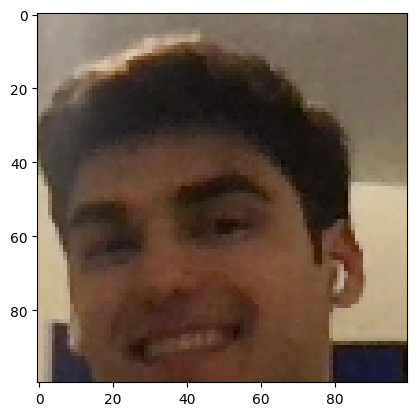

In [7]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
res = preprocess_twin(*example)
plt.imshow(res[1])

In [8]:
res[2]

1.0

In [9]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [10]:
# Section 4
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [11]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [12]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [4]:
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
l1 = L1Dist()

In [14]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [15]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [16]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [17]:
# Step 5
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [19]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [20]:
tf.losses.BinaryCrossentropy??

In [21]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [22]:
from tensorflow.keras.metrics import Precision, Recall
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [23]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
29/29 [==============================] - 205s 7s/step
0.029497143 0.61627907 0.9464286

 Epoch 2/50
29/29 [==============================] - 197s 7s/step
0.05216212 0.9537572 0.98802394

 Epoch 3/50
29/29 [==============================] - 196s 7s/step
0.043286473 0.9653179 1.0

 Epoch 4/50
29/29 [==============================] - 195s 7s/step
0.13190155 0.94219655 1.0

 Epoch 5/50
29/29 [==============================] - 195s 7s/step
0.0021509114 0.9705882 0.98802394

 Epoch 6/50
29/29 [==============================] - 196s 7s/step
0.0036942498 0.9771429 1.0

 Epoch 7/50
29/29 [==============================] - 194s 7s/step
0.09375429 0.9885057 1.0

 Epoch 8/50
29/29 [==============================] - 194s 7s/step
0.014257142 0.989011 1.0

 Epoch 9/50
29/29 [==============================] - 195s 7s/step
4.674264e-05 1.

In [24]:
# Part 6

from tensorflow.keras.metrics import Precision, Recall

test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[2.9517961e-09],
       [8.9633964e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.5211604e-08],
       [5.2332616e-08],
       [9.9999893e-01],
       [9.0673770e-04],
       [9.9732488e-01],
       [1.0000000e+00],
       [1.6006268e-06],
       [9.9997479e-01],
       [9.9576718e-01],
       [9.9999744e-01],
       [3.0198794e-07],
       [1.0000000e+00]], dtype=float32)

In [25]:
[ 1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]

In [26]:
y_true

array([0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

In [27]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [28]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [29]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 480ms/step
1.0 1.0


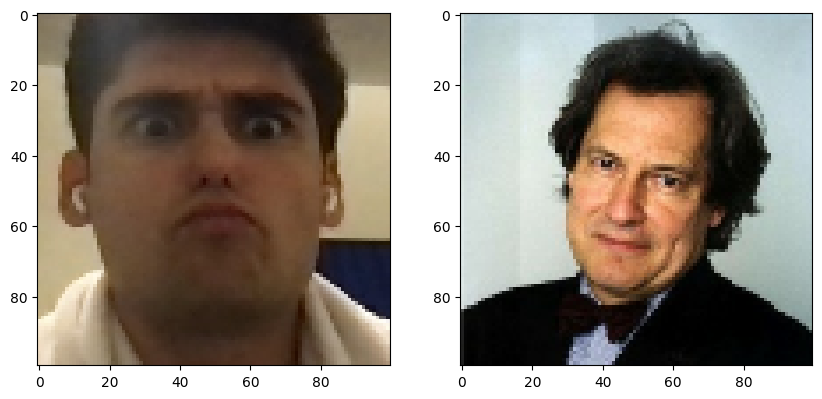

In [38]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[5])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[5])

# Renders cleanly
plt.show()

In [39]:
# Save weights
siamese_model.save('initial_test.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# STEP 8 : FINAL STEP!!!
import tensorflow as tf

siamese_model = tf.keras.models.load_model('initial_test.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [7]:
import cv2
import os

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[240:240+250, 500:500+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.7, 0.9)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyWindow('Verification')
cv2.waitKey(1)
cap.release()

1/1 [==============================] - 0s 107ms/step
True
1/1 [==============================] - 0s 108ms/step
False
1/1 [==============================] - 0s 108ms/step
False
1/1 [==============================] - 0s 120ms/step
True
1/1 [==============================] - 0s 108ms/step
False


In [50]:
np.sum(np.squeeze(results) > 0.9)

0